In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# Load data
model_type = "ols"
data_len = 1560 # 440, 660, 760, 1560
is_sent = True
predicted = "sp_close_lead1"

df_w = load_data(file_name=f"df_weekly_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_weekly_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [5]:
data_dict["model_features"].update(predicted=predicted)
data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# correlation

In [35]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     # 'ff_SMB',
     # 'ff_HML',
     # 'ff_RMW',
     # 'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     # 'sp_close_lag3',
     # 'sp_close_lag4',
     # 'sp_close_lag5',
     # 'sp_close_lag6',
     # 'sp_close_lag7',
]

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [36]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [37]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]] ,#+ ["sp_close"],
              data_dict["model_features"]["predicted"],
              show_plot=False,
             figsize=(5, 3))

[['vixo', 0, 0.47], ['ff_M_RF', 0, 0.468]]

In [38]:
# df_ws, _ = shift_var_relative_to_df(df_ws,
#                                  shift_var=["aaii_Bullish"],
#                                  no_lags=[7])
# data_dict["data_transformation"].update(shift_var=_)
# df_ws = df_ws.dropna()

# Multicolinerarity

In [39]:
# # orthogonalise
df_ws = orthogonalise_vars(df_ws, X="vixo", y="sp_close", show_fig=False)
df_ws = orthogonalise_vars(df_ws, X="sp_close", y="sp_close_lag1", show_fig=False)
df_ws = orthogonalise_vars(df_ws, X="sp_close", y="sp_close_lag2", show_fig=False)
df_ws = orthogonalise_vars(df_ws, X="sp_close_lag1", y="sp_close_lag2", show_fig=False)

,VIF,corr_sp_close_lead1
vixo,3.181921,-0.470477
sp_close_lag2,1.053566,-0.105876
sp_close_lag1,3.326139,0.320843
ff_M_RF,2.234124,0.468324
sp_close,1.623356,0.635878


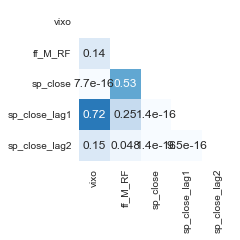

In [40]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             # size_factor=1,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["model_features"]["predicted"])

# Regression

In [41]:
df_train = df_ws.copy()

In [42]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.2,
                                            add_const=False)

In [43]:
model = SKLearnWrap(sm.OLS, fit_intercept=True)
model_ = model.fit(X_train, y_train)

In [44]:
data_dict["model_metrics"].update(featuer_sig=model.results_.pvalues)
model.results_.pvalues < .05

vixo              True
ff_M_RF           True
sp_close          True
sp_close_lag1    False
sp_close_lag2     True
intercept         True
dtype: bool

In [45]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     468.6
Date:                Mon, 14 Mar 2022   Prob (F-statistic):          6.73e-285
Time:                        15:39:59   Log-Likelihood:                 3654.4
No. Observations:                1272   AIC:                            -7297.
Df Residuals:                    1266   BIC:                            -7266.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo             -0.0799      0.006    -14.359      0.000      -0.091      -0.069
ff_M_RF           0.0021      0.001      4.088      0.000       0.001       0.003
sp_close          0.7498      0.026     29.267      0.000       0.700       0.800
sp_close_lag1     0.0040      0.035      0.116      0.908      -0.064       0.072
sp_close_lag2    -0.0788      0.028     -2.789      0.005      -0.134      -0.023
intercept         0.0015      0.000      3.901      0.000       0.001       0.002
==============================================================================
Omnibus:                      101.656   Durbin-Watson:                   2.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              551.891
Skew:                          -0.029   Prob(JB):                    1.44e-120
Kurtosis:                       6.226   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

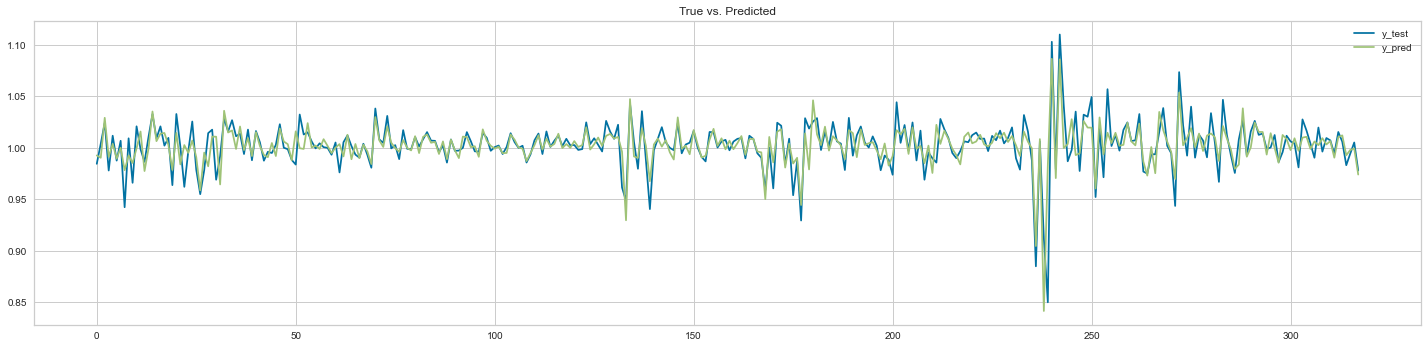

Validation Scores
mean squared error: 0.0002346454
mean absolute error: 0.009918185
R2: 0.5881821461


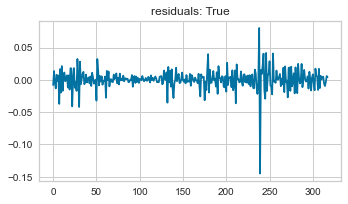

Stationarity Test Results
P-Values: 2.7383341038646924e-10
Test-stats: -7.175225926005161
Time series is stationary: True


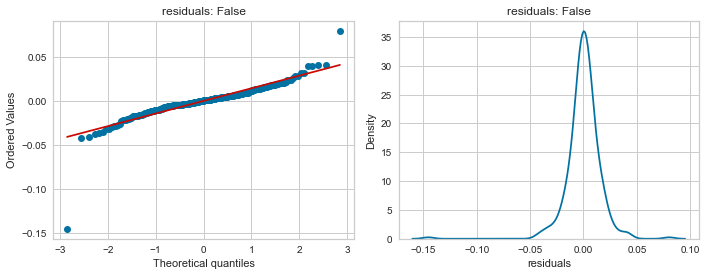

Normality Test Results
P-Values: 1.0802716256777618e-45
Test-stats: 207.07823333992178
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


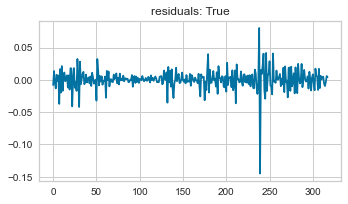

Test for Heteroskedasticity
Test p-value: 2.762313719134871e-47
Heteroskedasticity is present: True


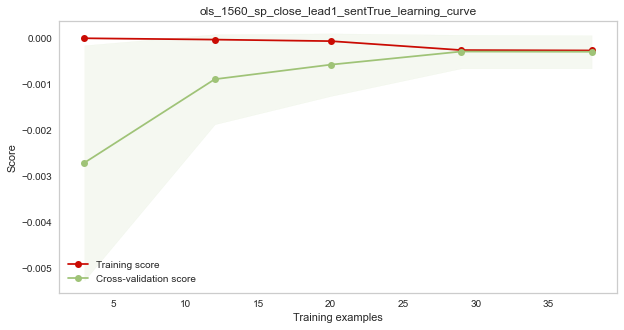

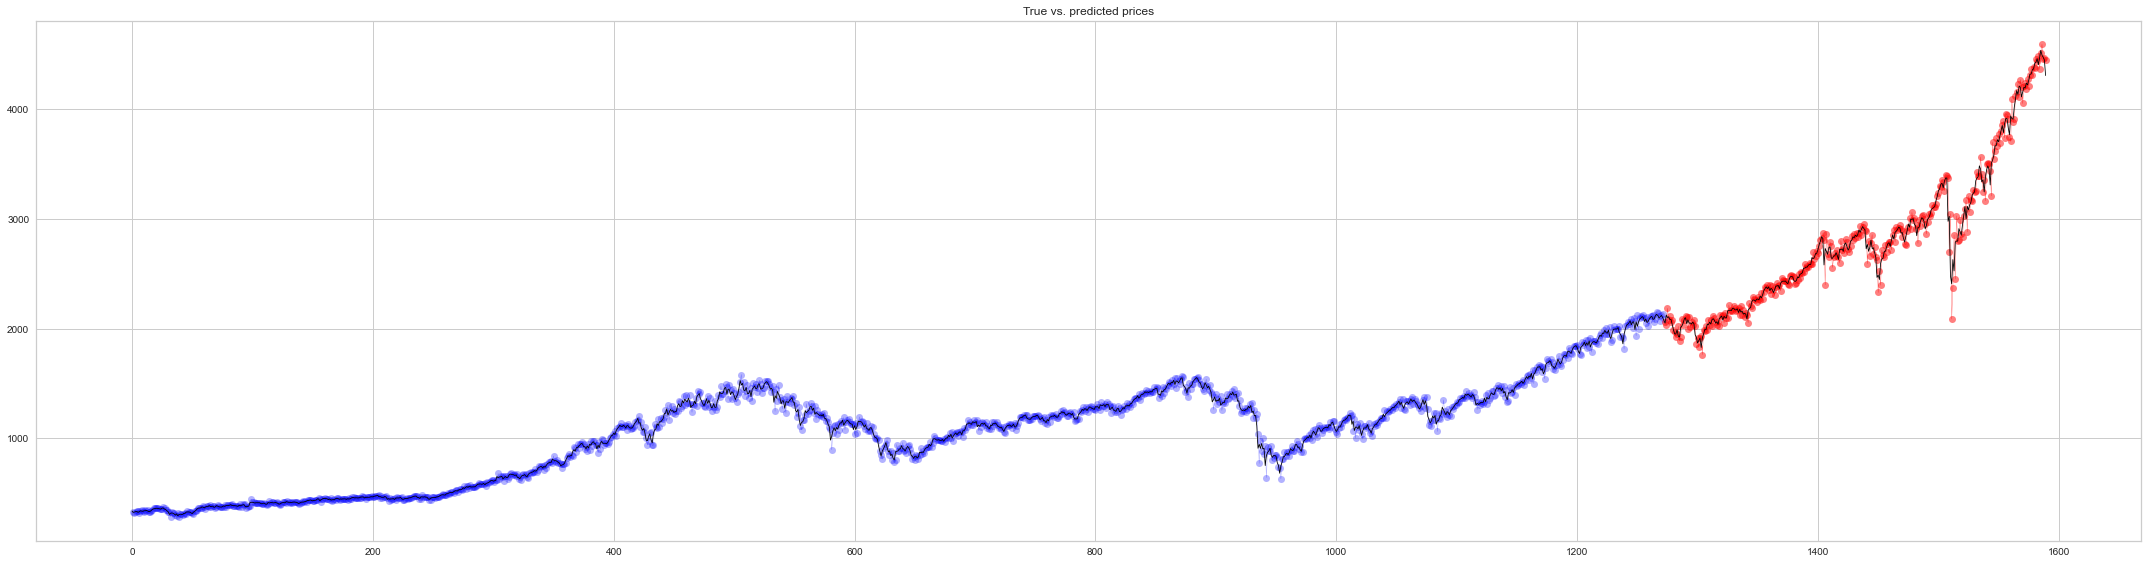

Validation Scores Test Data
mean squared error: 7958.2559286345
mean absolute error: 57.3083706694
mean absolute error in %: 0.04081049098559957
r2: 0.9816480382


In [46]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model,
            print_results=True)

fig_true_vs_fit = mval.get_model_performance()
stat, norm, hetero = mval.analyse_resids()

fig_lcurve = mval.sm_learning_curve(f"{data_dict['model_metrics']['model_name']}_learning_curve", n_splits=8)
fig_prices = mval.plot_results_on_price_scale(df_w,
                                              df_ws,
                                              sp_true_vals=data_dict["data"]["sp_true_vals"])

# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [47]:
save_model(model, df_train, data_dict, fig_true_vs_fit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-14_ols_1560_sp_close_lead1_sentTrue"? (y/n)


 y
